In [1]:
from pathlib import Path
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from math import floor
# from commpy.modulation import QAMModem
# from commpy.filters import rrcosfilter

## Resources

ETSI standard (*ETSI TS 102 361*):

1. [Air interface protocol](https://www.dmrassociation.org/downloads/standards/ts_10236101v020501p.pdf)
2. [DMR voice and generic services](https://www.dmrassociation.org/downloads/standards/ts_10236102v020401p.pdf)
3. [Data protocol](https://www.dmrassociation.org/downloads/standards/ts_10236103v010301p.pdf)
4. [Trunking protocol](https://www.dmrassociation.org/downloads/standards/ts_10236104v011001p.pdf)

[DMRDecode](https://github.com/IanWraith/DMRDecode) (Java)

[mbelib](https://github.com/szechyjs/mbelib) (C++)

## Asset / Example IQ File

[SDRSharp_20160101_231914Z_12kHz_IQ.wav](https://www.sigidwiki.com/wiki/File:DMR.zip)

Source: https://www.sigidwiki.com/wiki/Digital_Mobile_Radio_(DMR)



In [2]:
SYMBOL_RATE = 4800
SYMBOL_TIME = 1 / SYMBOL_RATE
PACKET_LENGTH_MS = 0.03
SYMBOLS_PER_PACKET = SYMBOL_RATE * PACKET_LENGTH_MS

In [15]:
# ETSI TS 102 361-1 Section 9.1.1
SYNC_PATTERN = {
    "BS_VOICE":                 "011101010101111111010111110111110111010111110111",
    "BS_DATA":                  "110111111111010101111101011101011101111101011101",
    "MS_VOICE":                 "011111110111110101011101110101010111110111111101",
    "MS_DATA":                  "110101011101011111110111011111111101011101010111",
    "MS_RC_SYNC":               "011101111101010101011111011111011111110101110111",
    "TDMA_DIRECT_SLOT_1_VOICE": "010111010101011101111111011101110101011111111111",
    "TDMA_DIRECT_SLOT_1_DATA":  "111101111111110111010101110111011111110101010101",
    "TDMA_DIRECT_SLOT_2_VOICE": "011111011111111111010101111101010101110101011111",
    "TDMA_DIRECT_SLOT_2_DATA":  "110101110101010101111111010111111111011111110101",
    "RESERVED_SYNC_PATTERN":    "110111010111111111110101110101110101011111011101"
}

In [3]:
def load_asset(name):
    base_path = Path(globals()['_dh'][0]).parent
    file_path = (base_path / "assets" / name).resolve()
    sample_rate, file = wavfile.read(file_path)
    print(f'Loaded {file_path}')
    num_channels = len(file.shape)
    length_s = round(file.shape[0]/sample_rate, 2)
    print(f'Sample rate: {sample_rate}Hz, channels: {num_channels}, samples: {file.shape[0]}, length: {length_s}s')
    
    return (sample_rate, file)


def save_wav(file, fs, file_path='/tmp/test.wav'):
    # normalize volume
    frames = (file * (20000 / np.max(file))).astype('int16')

    w = wave.open(file_path, mode='wb')
    w.setnchannels(1)
    w.setframerate(fs)
    w.setsampwidth(2)
    w.writeframes(frames)
    w.close()
    
    print(f'Saved file to {file_path} - {round(len(file)/fs, 2)}s @ {fs}Hz')

def show_waveform(file, fs, comment=''):
    fig, ax = plt.subplots()
    ax.plot([ (n*1000)/fs for n in range(0, len(file)) ], file)
    ax.set_title(f'Waveform - {comment}')
    
    for offset in range(0, floor((len(file)/fs)/SYMBOL_TIME)+1, 2):
        ax.axvspan(offset*SYMBOL_TIME * 1000, (offset + 1) * SYMBOL_TIME * 1000, alpha=0.2, color='pink')

    fig.set_figwidth(20)
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Amplitude')
    

def show_spectrogram(x, fs, comment=''):
    f, t, Sxx = signal.spectrogram(x, fs)

    fig, ax = plt.subplots()
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
#     ax.axhspan(1200-10, 1200+10, alpha=0.2, color='pink')
#     ax.axhspan(2200-10, 2200+10, alpha=0.2, color='pink')
    fig.set_figwidth(20)
    ax.set_ylim([0,8000])
    ax.set_title(f'Spectrogram - {comment}')

In [4]:
class RootRaisedCosineFilter:
    # Translated from the DMRDecode project https://github.com/IanWraith/DMRDecode

    def __init__(self):
        self.N_ZEROS = 80
        self.xv = [ 0.0 for i in range(0, self.N_ZEROS+2) ]
        self.xv_counter = 0

        self.GAIN = 9.868410946e+00
        self.X_COEFFS = [
            +0.0273676736, +0.0190682959, +0.0070661879, -0.0075385898,
            -0.0231737159, -0.0379433607, -0.0498333862, -0.0569528373,
            -0.0577853377, -0.0514204905, -0.0377352004, -0.0174982391,
            +0.0076217868, +0.0351552125, +0.0620353691, +0.0848941519,
            +0.1004237235, +0.1057694293, +0.0989127431, +0.0790009892,
            +0.0465831968, +0.0037187043, -0.0460635022, -0.0979622825,
            -0.1462501260, -0.1847425896, -0.2073523972, -0.2086782295,
            -0.1845719273, -0.1326270847, -0.0525370892, +0.0537187153,
            +0.1818868577, +0.3256572849, +0.4770745929, +0.6271117870,
            +0.7663588857, +0.8857664963, +0.9773779594, +1.0349835419,
            +1.0546365475, +1.0349835419, +0.9773779594, +0.8857664963,
            +0.7663588857, +0.6271117870, +0.4770745929, +0.3256572849,
            +0.1818868577, +0.0537187153, -0.0525370892, -0.1326270847,
            -0.1845719273, -0.2086782295, -0.2073523972, -0.1847425896,
            -0.1462501260, -0.0979622825, -0.0460635022, +0.0037187043,
            +0.0465831968, +0.0790009892, +0.0989127431, +0.1057694293,
            +0.1004237235, +0.0848941519, +0.0620353691, +0.0351552125,
            +0.0076217868, -0.0174982391, -0.0377352004, -0.0514204905,
            -0.0577853377, -0.0569528373, -0.0498333862, -0.0379433607,
            -0.0231737159, -0.0075385898, +0.0070661879, +0.0190682959,
            +0.0273676736
        ]
    
    def filter_sample(self, sample):
        sum = 0.0

        # Add the latest sample to the xv circular buffer
        self.xv[self.xv_counter] = (float(sample) / self.GAIN)

        # Increment the circular buffer counter and zero it if needed
        self.xv_counter = self.xv_counter + 1
        if self.xv_counter == (self.N_ZEROS+1):
            self.xv_counter = 0

        # Do the RRC maths taking account of the fact that XV is a circular buffer
        xvShadow = self.xv_counter

        for i in range(0, self.N_ZEROS + 1):
            sum = sum + (self.X_COEFFS[i] * self.xv[xvShadow])
            xvShadow = xvShadow + 1
            if xvShadow == (self.N_ZEROS + 1):
                xvShadow=0

        return int(sum)

Loaded /home/personal/code/dmr-from-scratch/assets/SDRSharp_20160101_231914Z_12kHz_real_720ms.wav
Sample rate: 44100Hz, channels: 1, samples: 31753, length: 0.72s


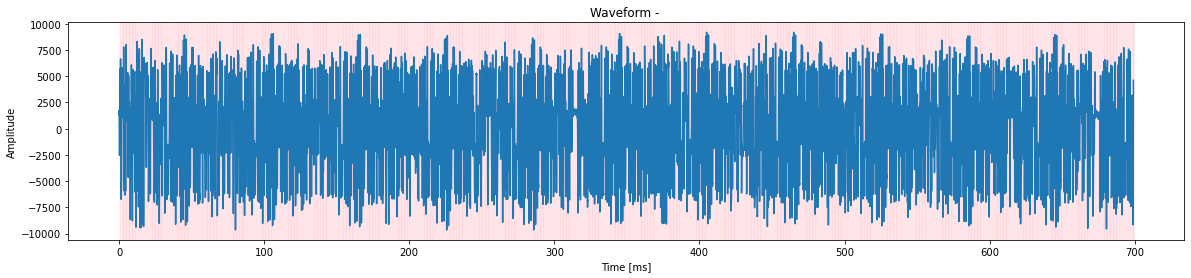

In [5]:
fs_real, rec_real = load_asset('SDRSharp_20160101_231914Z_12kHz_real_720ms.wav')
rrcos = RootRaisedCosineFilter()

fs = 48000
rec_real_resampled = signal.resample(rec_real, int((fs/fs_real) * len(rec_real)))


rec_real_resampled_filtered = np.array([ rrcos.filter_sample(b) for b in rec_real_resampled ])

show_waveform(rec_real_resampled[1000:55000], fs)

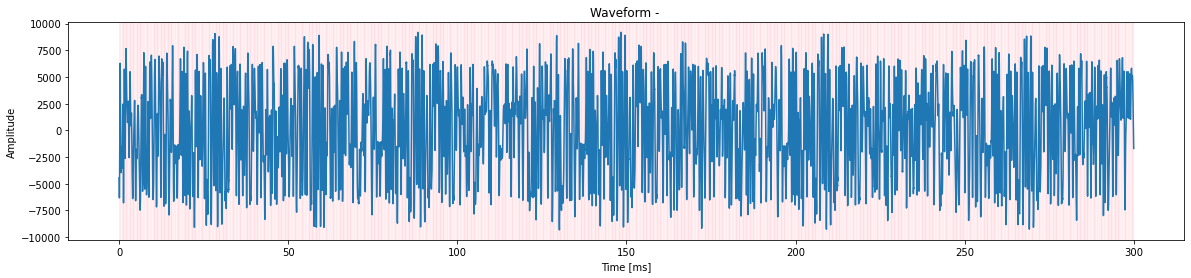

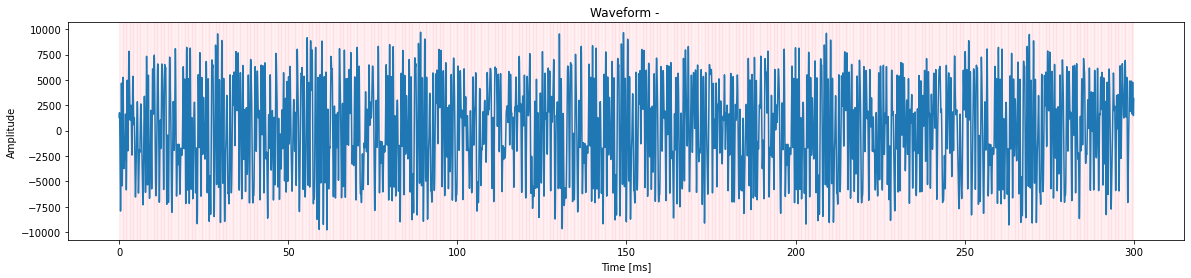

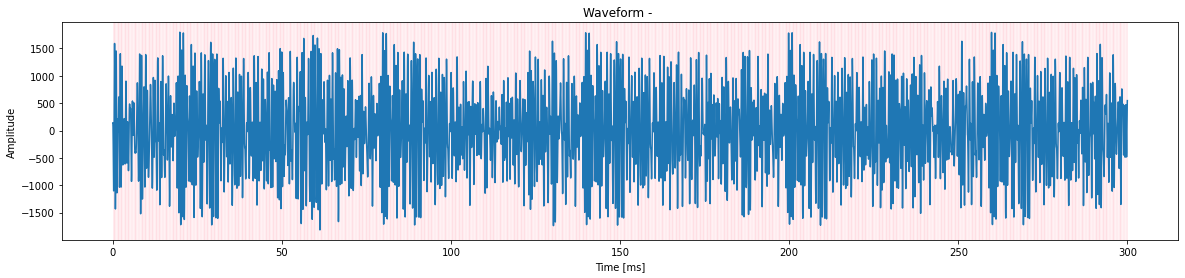

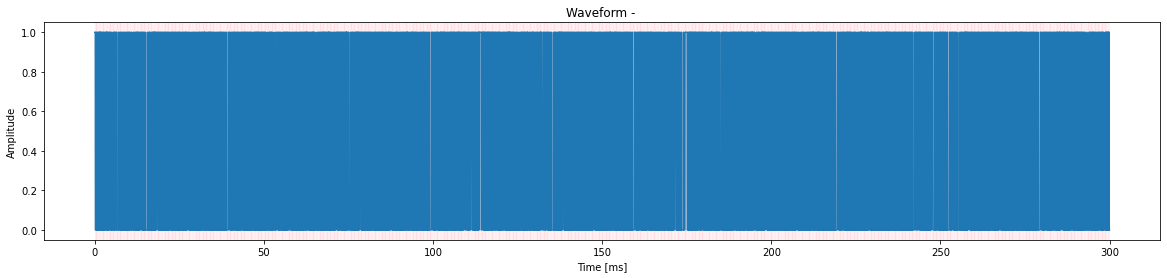

In [6]:
start = 0.0075 + 0.03*11
end = start + 0.03*10

show_waveform(rec_real_resampled[round(fs*start):round(fs*end)], fs)
show_waveform(rec_real_resampled_filtered[round(fs*start):round(fs*end)], fs)
show_waveform(np.diff(rec_real_resampled_filtered)[round(fs*start):round(fs*end)], fs)
show_waveform((np.abs(np.diff(rec_real_resampled_filtered))<200)[round(fs*start):round(fs*end)], fs)

Audio(rec_real_resampled[int(fs*start):round(fs*end)], autoplay=False, rate=fs)


In [16]:
# x = (rec_real_resampled_filtered)[round(fs*start):round(fs*end)]
x = rec_real_resampled_filtered
SAMPLES_PER_SYMBOL = 10

np.argmax([ np.max([ np.std(x[packet_step*SAMPLES_PER_SYMBOL+offset::SAMPLES_PER_SYMBOL]) for offset in range(0, SAMPLES_PER_SYMBOL) ]) for packet_step in range(0,30) ])


# show_waveform(x[1443:1443*2], fs)


packet_offset = 17
sample_offset = 3
picked = rec_real_resampled_filtered[packet_offset*SAMPLES_PER_SYMBOL+sample_offset::10]

# plt.hist(picked, bins=100)

middle = (np.quantile(picked,0.05)+np.quantile(picked,0.95))/2

bins = [np.min(picked)-1, (np.min(picked)+middle)/2, middle, (np.max(picked)+middle)/2, np.max(picked)+1]

def to_dibit(input):
    # Convert bin number e [1, 4] to dibit
    return {
        1: "01", # 1, # 01
        2: "00", # 0, # 00
        3: "10", # 2, # 10
        4: "11", # 3  # 11
    }[input]

''.join([ to_dibit(s) for s in np.digitize(picked, bins, right=True) ])

'011101010101111111010111110111110111010111110111010100101001010111000100111011001111101111011011000111100010011000001100011111100101011011001011101000011110101101101100000101100011001110010100111010101011110110100110011111101010101100001100101010010110001110100101111010001011100110100101110111111111010101111101011101011101111101011101011111111111111000001111111011000100001010100111111010101010111111000101011011011000101000011110100110010110000010100010011110101010111110010110100011110100000000010000001011001101101101110110110110010010100100010111001110011100101000001110011101010101111111010111110111110111010111110111010100101001010111000100111011001111101111011011000111100010011000001100011111100101011011001011101000011110101000100000011000010011001010100100110010001010110111000111011011011010100000011111111111010100000110000111110010001000101111000101100010011010110010101111101001101010110001101110001111101010110001011111111011010111000010100111111111001001110110100011100100100110010

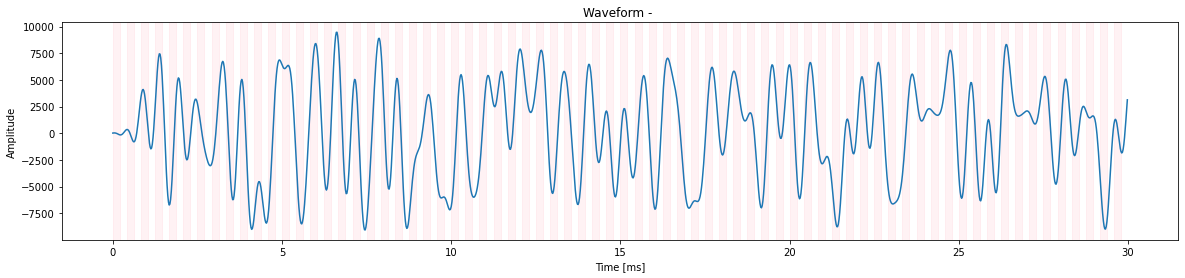

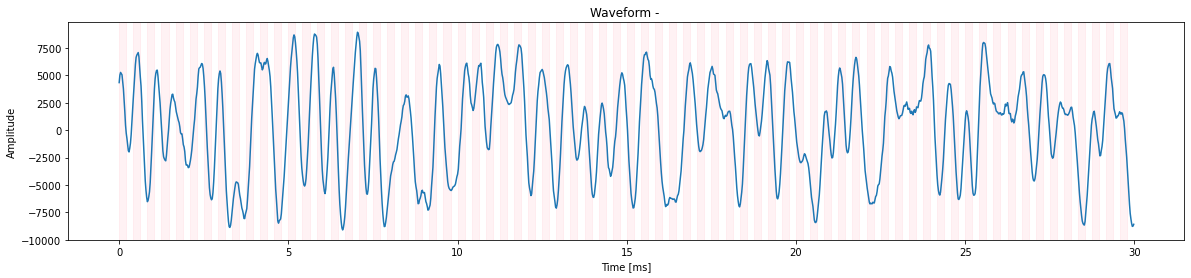

In [9]:
one_packet = rec_real_resampled_filtered[int(fs*0):round(fs*0.030)]
show_waveform(one_packet, fs)

show_waveform(rec_real_resampled[int(fs*0):round(fs*0.030)], fs)

#show_spectrogram(rec_real_resampled_filtered[fs*5:fs*10], fs)
#show_spectrogram(rec_real_resampled[fs*5:fs*10], fs)
